In [82]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

s = 3 # index of the simulation we want to have a closer look on
tw_s = [10, 10, 10, 10, 20, 20] # time window lengths in the simulated data
tw = tw_s[s] 


#--------------------------------------------------
# Read data produced with different settings of kf
#--------------------------------------------------

np_t = [] # list for outputs with settings. invm = numpy.linalg.inv, useKG = True
np_f = [] # invm = np.linalg.inv, useKG = False
bl_t = [] # invm = block_inv, useKG = True
bl_f = [] # invm = block_inv, useKG = False



for i in range(6): # read data from simulations

    np_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_default_with_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    bl_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_block_with_kf/*.nc",
                        concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    np_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_default_without_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))
    
    bl_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_block_without_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

#------------------------------------------------------------------------------
# Had to read matrices in another way, as open_mfdataset didn't work with them
#----------------------------------------------------------------------------

def read_matrices(sim, subfilename):
    """Helper function to read output matrices from simulation instance sim.
    """
    B = [] # prior covariance matrices
    A = [] # posterior covariance matrices
    R = [] # observation error covariance matrices

    for i in range(5):
        filepath = f"simulated_data/simulation_0{sim}/{subfilename}/s0{sim}_out_0{i}.nc"
        data = xr.open_dataset(filepath)
        B.append(data["prior_cov"])
        A.append(data["posterior_cov"])
        R.append(data["obs_unc"])
    return B, A, R

B_np, A_np, R_np = read_matrices(s, 'out_default_with_kf')
B_bl, A_bl, R_bl = read_matrices(s, "out_block_with_kf")

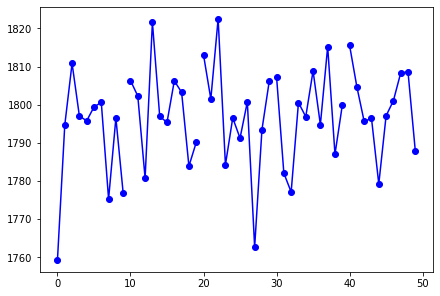

Posterior state
----------------

Changes so small that if I try to plot all nstates in the same plot, changes won't show, because plot will be too much zoomed out.
Better to plot one at a time as an example / sanity check

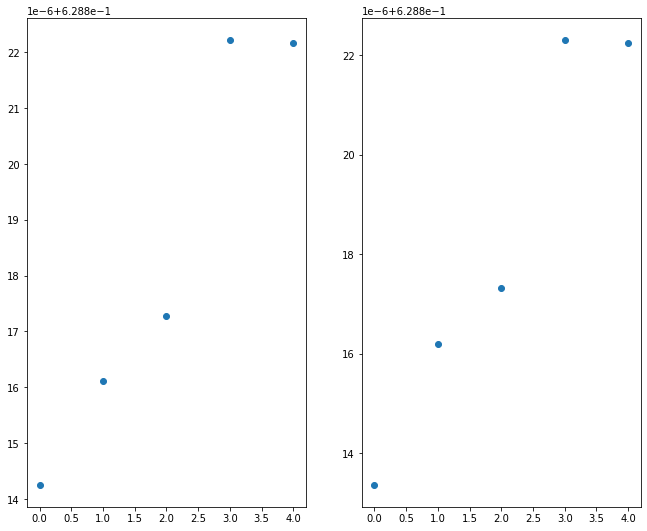

In [83]:


dat1 = np_t[s].posterior.isel(nstate = 2)
dat2 = bl_t[s].posterior.isel(nstate = 2)


fig, axs = plt.subplots(1,2, figsize = (11,9))
axs[0].plot(dat1, 'o') # marker = 'o', color = 'red', alpha = 0.7)
axs[1].plot(dat2, 'o') #, dat2[4,:].values, marker = 'd', linestyle = 'dashed', color = 'blue', alpha = 0.7)
plt.show()



Obs - prior differences
-----------------------
Below plotted for the whole time, including the first time window, in which
differences significantly larger.

Maybe better to exclude the first time window from the plot?

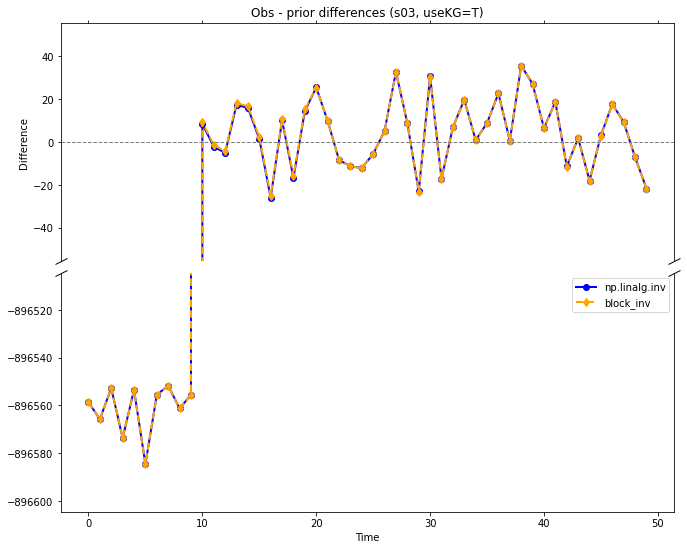

In [84]:
#-----------------------------------------------------
# Change data into a more suitable format for plotting 
#-----------------------------------------------------


# E.g. in s01 data.differences of each timewindow have shape (1,50) even though
# the actual time window is shorter than 50. Let's pick the slice of 
# the total time that corresponds to each time window (shape (1.10)) and 
# recombine these slices into a single dataArray of shape (1,50)



da1 = np_t[s].differences 
da2 = bl_t[s].differences
da3 = np_f[s].differences
da4 = bl_f[s].differences 

ls1 = []
ls2 = []
ls3 = []
ls4 = []

for i in range(5):
    ls1.append(da1[i,i*tw:(i+1)*tw])
    ls2.append(da2[i,i*tw:(i+1)*tw])
    ls3.append(da3[i,i*tw:(i+1)*tw])
    ls4.append(da4[i,i*tw:(i+1)*tw])
np_t_dif = xr.concat(ls1, dim = 'time')
bl_t_dif = xr.concat(ls2, dim = 'time')
np_f_dif = xr.concat(ls3, dim = 'time')
bl_f_dif = xr.concat(ls4, dim = 'time')


#--------------------------------------------
# Plot with discontinuous y-axis
#--------------------------------------------

#split y-axis into two by creating two subplots on
# top of each other
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (11,9))
fig.subplots_adjust(hspace=0.05)

# same data on both axes
ax1.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
ax2.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
ax1.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv") 
ax2.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv")

ax1.axhline(y=0,linewidth= 1, color='grey', linestyle= 'dashed')

minval = np_t_dif.min()-20
maxval = np_t_dif.max()+20

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(-maxval, maxval)  # most of the data
ax2.set_ylim(minval, minval+100)  # outliers only

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Time")
ax2.legend()
ax1.set_ylabel("Difference")
ax1.set_title(f"Obs - prior differences (s0{s}, useKG=T)")



plt.show()




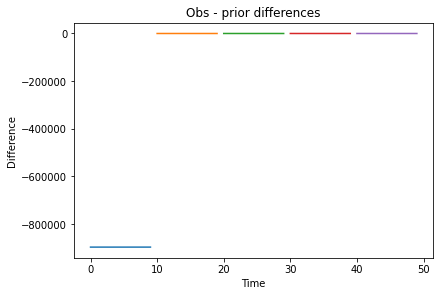

In [85]:
data = np_t[s]
fig, ax = plt.subplots(layout = 'constrained')
ax.plot(data['time'], data['differences'].transpose())
ax.set_ylabel('Difference')
ax.set_xlabel('Time')
ax.set_title('Obs - prior differences')
plt.show()


Covariance and observation uncertainty matrices
------------------------------------------------

ValueError: vmin, vcenter, and vmax must be in ascending order

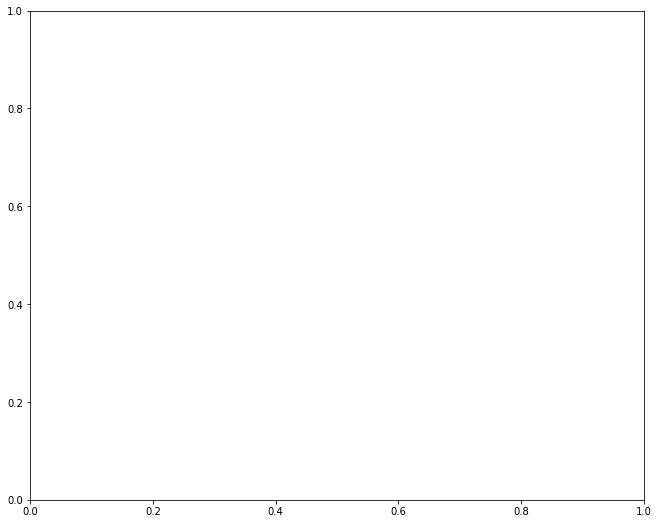

In [120]:
M = A_np[4]

qlower = np.quantile(M, 0.01)
qupper = np.quantile(M, 0.99)

fig, ax = plt.subplots(figsize = (11,9))
norm = colors.TwoSlopeNorm(vmin = min(0,qlower), vcenter = 0, vmax = qupper)
M.plot.imshow(ax=ax, yincrease = False, norm = norm)
plt.show()


Multiple subplots in same figure

* turns out the colorbar normalation is tricky


The easiest but ugliest way out: each subplot has its own colorbar, and colorbar ranges differ.


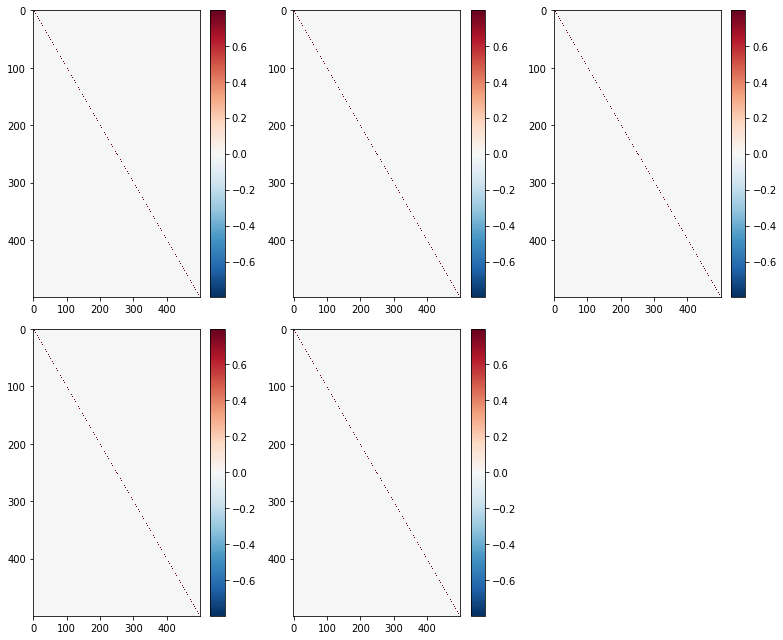

In [93]:

fig, axs = plt.subplots(2,3, figsize = (11,9))
axs[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    A_np[k].plot.imshow(ax = axs[i,j], yincrease = False, add_labels = False)
plt.tight_layout()
plt.show()



QUANTILES + SYMLOGNORM

Problem with SymLogNorm: plots a really nice plot but the colormap doesn't center at zero

Colorbar min and max set manually to certain quantiles.
Alfa has to be really small < 10**(-3) 
Otherwise all but the first subplot seem to become uniformly one color
because such an immense part of the values within very small range around zero


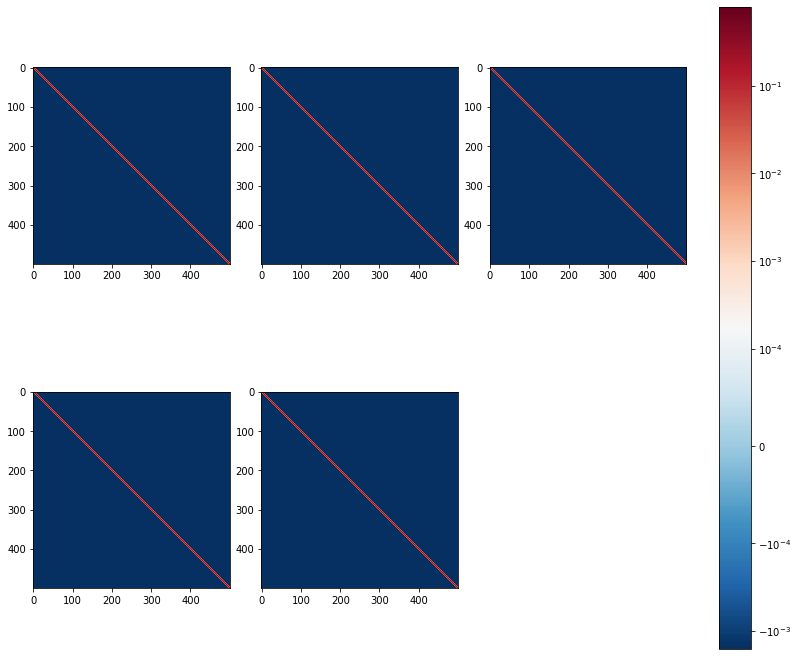

In [96]:

fig, axs = plt.subplots(2,3, figsize = (11,9), layout = 'constrained')
axs[-1,-1].axis('off')

images = []
for k in range(5):
    i = k // 3
    j = k - 3*i
    images.append(axs[i,j].imshow(A_np[k], cmap = 'RdBu_r'))
    #axs[i, j].label_outer()

# Find the quantiles to use as colorbar min and max

    
qlower = min(np.quantile(A.values, 0.001) for A in A_np)
qupper = max(np.quantile(A.values, 0.999) for A in A_np)
vmin = min(A.values.min() for A in A_np)
vmax = max(A.values.max() for A in A_np)

norm = colors.SymLogNorm(vmin=vmin, vmax = vmax, linthresh = 10**(-4))
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm)
plt.show()


From stackexchange: 

This is for the more complex case where the values are not just between 0 and 1; the cmap needs to be shared instead of just using the last one.


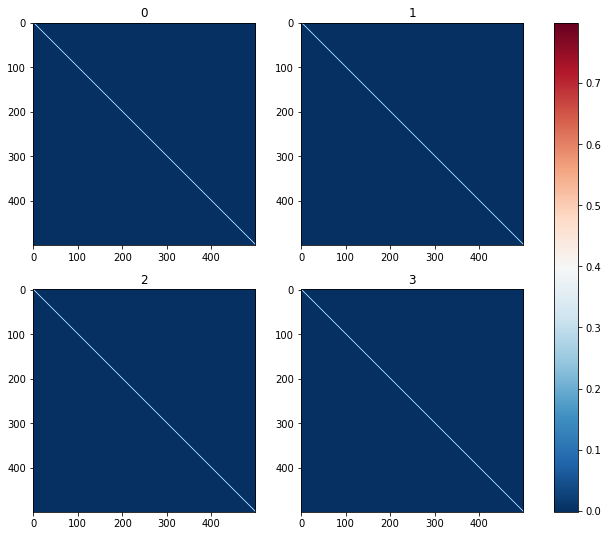

In [104]:



import matplotlib.cm as cm
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (11, 9))
cmap=cm.get_cmap('viridis')
normalizer=colors.Normalize(vmin, vmax)
im=cm.ScalarMappable(norm=normalizer, cmap = cmap)
for i,ax in enumerate(axes.flat):
    ax.imshow(A_np[i],cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Another one from stackexchange

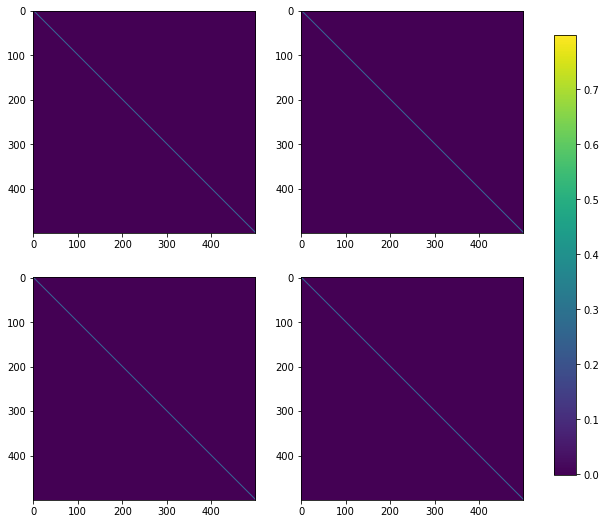

In [110]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (11,9))
i = 1
for ax in axs.flat:
    plt.sca(ax)
    plt.imshow(A_np[i], cmap='viridis')
    i += 1
plt.colorbar(ax=axs.ravel().tolist(), shrink=0.9)
plt.show()




How about matshow?



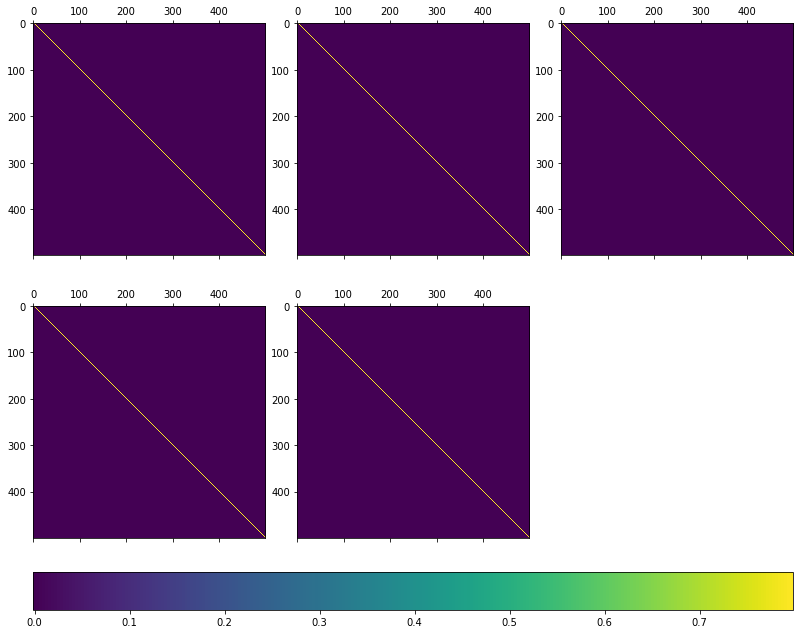

In [92]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (11,9), layout = 'constrained')
axes[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    im = axes[i,j].matshow(A_np[k])

fig.colorbar(im, ax=axes.ravel().tolist(), norm = colors.Normalize(vmin = vmin, vmax = vmax), location = 'bottom')

plt.show()